# Importing Required Libraries
Loads essential libraries for:
- Data processing (`pandas`, `numpy`, `torch`)
- Image processing (`cv2`, `PIL`, `torchvision.transforms`)
- Data visualization (`matplotlib`, `seaborn`)
- Model training (`torch.nn`, `torch.optim`)
- Performance evaluation (`sklearn.metrics`)

In [11]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# Loading and Organizing Data
Reads image file paths and their corresponding labels from the dataset folder.
Valid class names are AD, CN, EMCI, and LMCI. The data is stored in a pandas DataFrame.

In [15]:
import os
import pandas as pd
from tqdm import tqdm

# Define the path to the dataset and valid class names
path = "/content/kagglehub/datasets/ahmedashrafahmed/fdata-adni-dataset/versions/1"
valid_classes = ['AD', 'CN', 'EMCI', 'LMCI']

images = []
labels = []

# Iterate through subfolders
for subfolder in tqdm(os.listdir(path)):
    subfolder_path = os.path.join(path, subfolder)
    if os.path.isdir(subfolder_path):  # Ensure it's a directory
        for folder in os.listdir(subfolder_path):
            if folder in valid_classes:  # Only process valid class folders
                subfolder_path2 = os.path.join(subfolder_path, folder)
                if os.path.isdir(subfolder_path2):
                    for image_filename in os.listdir(subfolder_path2):
                        image_path = os.path.join(subfolder_path2, image_filename)
                        images.append(image_path)
                        labels.append(folder)

# Create a DataFrame
df = pd.DataFrame({'image': images, 'label': labels})
print(f"Total samples: {len(df)}")
print(df['label'].value_counts())
df

100%|██████████| 1/1 [00:00<00:00, 20.38it/s]

Total samples: 33984
label
EMCI    9600
AD      8960
LMCI    8960
CN      6464
Name: count, dtype: int64


image label
0      /content/kagglehub/datasets/ahmedashrafahmed/f...    AD
1      /content/kagglehub/datasets/ahmedashrafahmed/f...    AD
2      /content/kagglehub/datasets/ahmedashrafahmed/f...    AD
3      /content/kagglehub/datasets/ahmedashrafahmed/f...    AD
4      /content/kagglehub/datasets/ahmedashrafahmed/f...    AD
...                                                  ...   ...
33979  /content/kagglehub/datasets/ahmedashrafahmed/f...  EMCI
33980  /content/kagglehub/datasets/ahmedashrafahmed/f...  EMCI
33981  /content/kagglehub/datasets/ahmedashrafahmed/f...  EMCI
33982  /content/kagglehub/datasets/ahmedashrafahmed/f...  EMCI
33983  /content/kagglehub/datasets/ahmedashrafahmed/f...  EMCI

[33984 rows x 2 columns]

# Visualising Class Distribution
Uses a Seaborn count plot to show the number of samples per class in the dataset.
This helps in understanding class imbalance.

<ipython-input-16-be9dd1228c04>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label,palette='Set1')


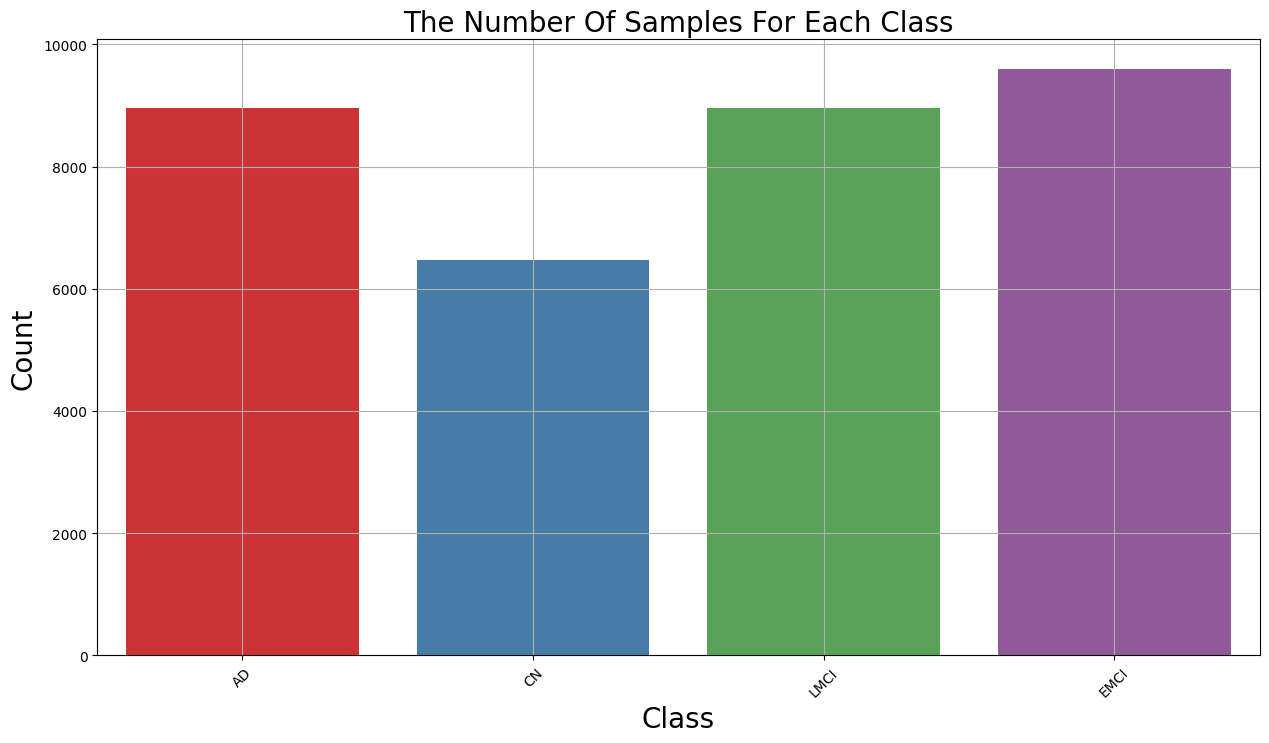

In [16]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Displaying Sample Images
Randomly selects and displays 50 images from the dataset.
Each image is resized to 224x224 pixels and shown with its corresponding label.

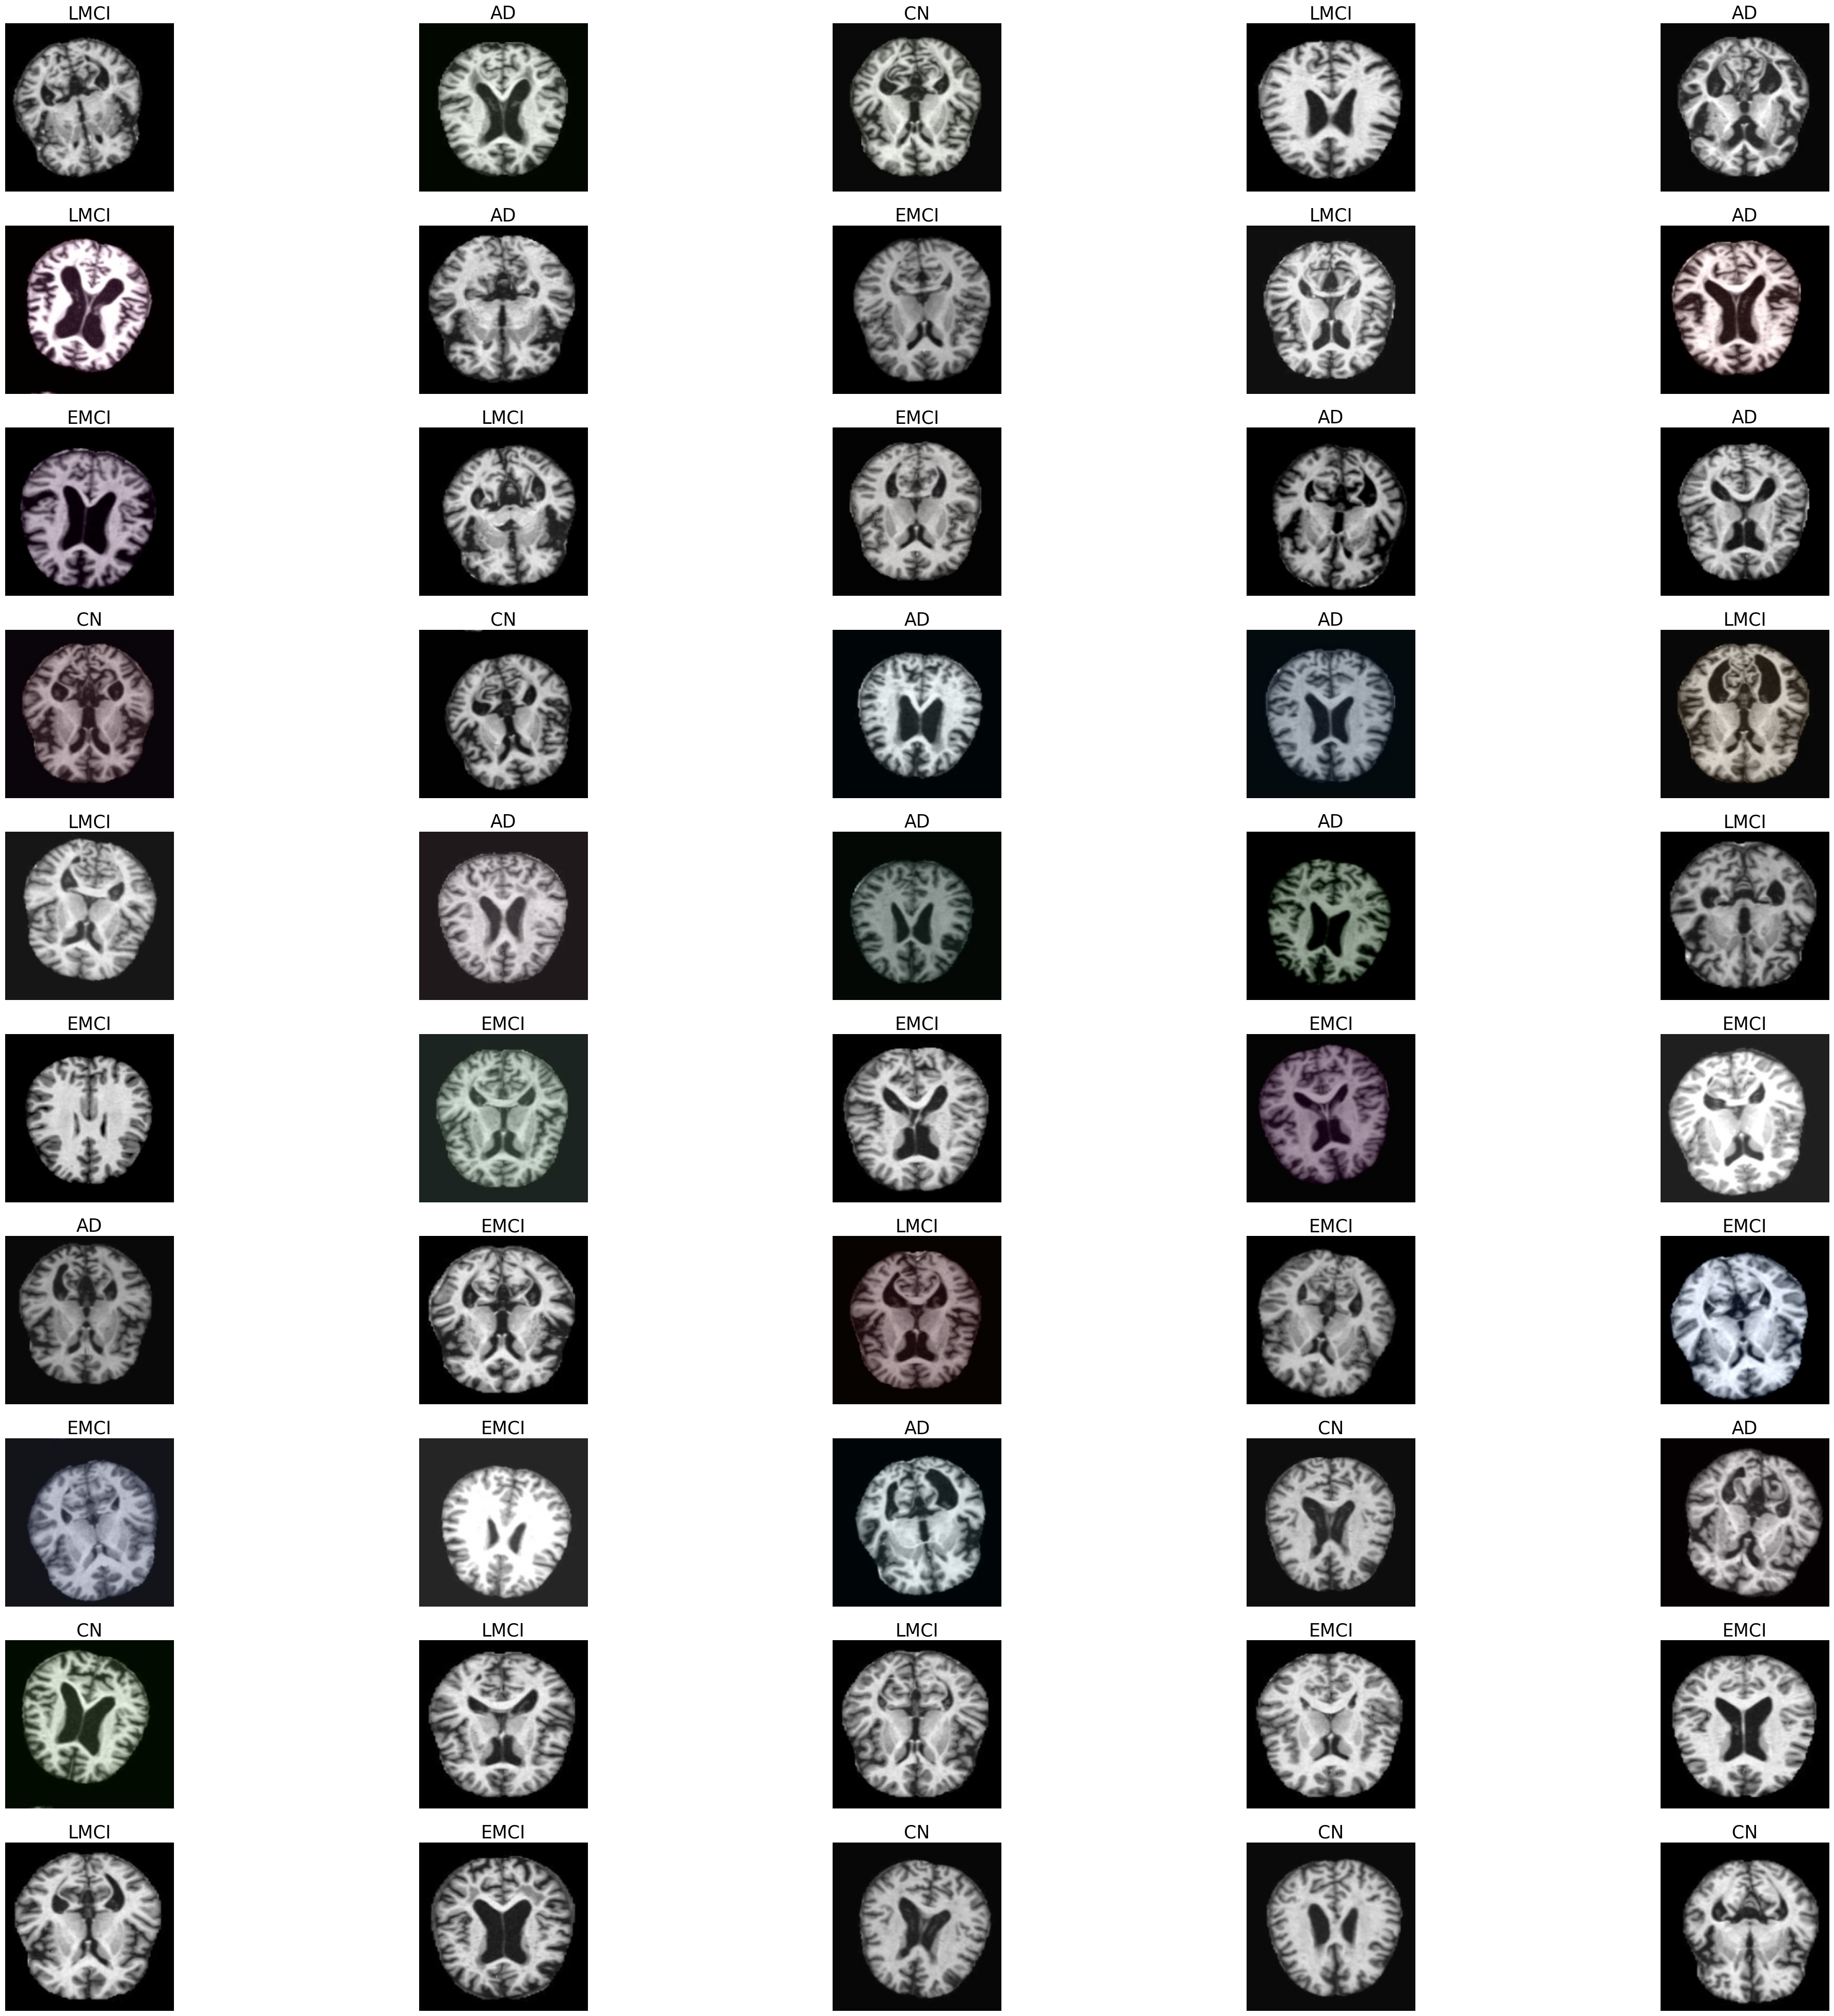

In [17]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

# Image Preprocessing with Transformations
Applies various transformations to prepare images for model training, including:
- Resizing
- Converting to tensors
- Normalization

# Creating a Custom Dataset Class
Defines a PyTorch dataset class that loads images, applies transformations, and returns label-encoded data.

# Splitting Data into Train, Validation, and Test Sets
Splits the dataset into training, validation, and test sets using an 80-10-10 split.

# Creating Data Loaders
Uses PyTorch DataLoader to efficiently load images in batches for training and evaluation.

In [18]:
from torch.utils.data import Dataset
import cv2
import torch
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label']

        img = Image.open(img_path).convert("RGB")  # Open image correctly

        if self.transform:
            img = self.transform(img)  # Apply transforms

        return img, torch.tensor(label, dtype=torch.long)  # Convert label to tensor


# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['label'])

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create datasets
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
class_num = list(label_encoder.inverse_transform(train_df['label'].unique()))
class_num

['EMCI', 'CN', 'LMCI', 'AD']

# Defining the CNN Model
Builds a simple Convolutional Neural Network (CNN) model for classification.
The model consists of convolutional layers, activation functions, pooling layers, and fully connected layers.

In [20]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers with BatchNorm and adjusted dropout
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Add BatchNorm for stability
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Add BatchNorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Add BatchNorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers with increased dropout
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.BatchNorm1d(256),  # Add BatchNorm for dense layers
            nn.ReLU(),
            nn.Dropout(0.5),  # Increase dropout rate to 0.5

            nn.Linear(256, 128),  # Add an additional hidden layer
            nn.BatchNorm1d(128),  # Add BatchNorm
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout again

            nn.Linear(128, 4)  # Output layer for 4 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)

# Loss function and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.000125, weight_decay=1e-4)  # Add L2 regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Reduce LR every 20 epochs

print(model)

CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): BatchNorm1d(256, ep

# Training the CNN Model
Defines the training loop with loss computation and weight updates.
Uses Adam optimizer and cross-entropy loss.

In [21]:
import pandas as pd

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100):
    history = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_acc': [], 'learning_rate': []}
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device).float(), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).float(), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_2.pth")

        # Step the scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Store metrics
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(current_lr)

        # Display metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Learning Rate: {current_lr:.6f}")

    # Convert history to DataFrame
    hist_ = pd.DataFrame(history)
    return hist_

# Example usage
hist_ = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100)

100%|██████████| 850/850 [02:14<00:00,  6.32it/s]


Epoch [1/100], Loss: 1.0724, Accuracy: 0.5131, Validation Accuracy: 0.6215, Learning Rate: 0.000125


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [2/100], Loss: 0.8137, Accuracy: 0.6366, Validation Accuracy: 0.6928, Learning Rate: 0.000125


100%|██████████| 850/850 [02:14<00:00,  6.32it/s]


Epoch [3/100], Loss: 0.7079, Accuracy: 0.6944, Validation Accuracy: 0.7560, Learning Rate: 0.000125


100%|██████████| 850/850 [02:14<00:00,  6.31it/s]


Epoch [4/100], Loss: 0.6309, Accuracy: 0.7284, Validation Accuracy: 0.7472, Learning Rate: 0.000125


100%|██████████| 850/850 [02:13<00:00,  6.38it/s]


Epoch [5/100], Loss: 0.5715, Accuracy: 0.7620, Validation Accuracy: 0.8196, Learning Rate: 0.000125


100%|██████████| 850/850 [02:13<00:00,  6.39it/s]


Epoch [6/100], Loss: 0.5230, Accuracy: 0.7824, Validation Accuracy: 0.8058, Learning Rate: 0.000125


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [7/100], Loss: 0.4837, Accuracy: 0.8048, Validation Accuracy: 0.8443, Learning Rate: 0.000125


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [8/100], Loss: 0.4484, Accuracy: 0.8156, Validation Accuracy: 0.8328, Learning Rate: 0.000125


100%|██████████| 850/850 [02:12<00:00,  6.39it/s]


Epoch [9/100], Loss: 0.4145, Accuracy: 0.8326, Validation Accuracy: 0.8729, Learning Rate: 0.000125


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [10/100], Loss: 0.3903, Accuracy: 0.8434, Validation Accuracy: 0.8693, Learning Rate: 0.000125


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [11/100], Loss: 0.3694, Accuracy: 0.8519, Validation Accuracy: 0.8693, Learning Rate: 0.000125


100%|██████████| 850/850 [02:14<00:00,  6.32it/s]


Epoch [12/100], Loss: 0.3410, Accuracy: 0.8666, Validation Accuracy: 0.8882, Learning Rate: 0.000125


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [13/100], Loss: 0.3222, Accuracy: 0.8739, Validation Accuracy: 0.8976, Learning Rate: 0.000125


100%|██████████| 850/850 [02:12<00:00,  6.40it/s]


Epoch [14/100], Loss: 0.3092, Accuracy: 0.8793, Validation Accuracy: 0.9085, Learning Rate: 0.000125


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [15/100], Loss: 0.2938, Accuracy: 0.8866, Validation Accuracy: 0.9011, Learning Rate: 0.000125


100%|██████████| 850/850 [02:12<00:00,  6.40it/s]


Epoch [16/100], Loss: 0.2838, Accuracy: 0.8896, Validation Accuracy: 0.9185, Learning Rate: 0.000125


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [17/100], Loss: 0.2645, Accuracy: 0.8979, Validation Accuracy: 0.9191, Learning Rate: 0.000125


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [18/100], Loss: 0.2547, Accuracy: 0.9022, Validation Accuracy: 0.9152, Learning Rate: 0.000125


100%|██████████| 850/850 [02:12<00:00,  6.40it/s]


Epoch [19/100], Loss: 0.2416, Accuracy: 0.9057, Validation Accuracy: 0.9191, Learning Rate: 0.000125


100%|██████████| 850/850 [02:13<00:00,  6.38it/s]


Epoch [20/100], Loss: 0.2365, Accuracy: 0.9102, Validation Accuracy: 0.9135, Learning Rate: 0.000063


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [21/100], Loss: 0.2019, Accuracy: 0.9236, Validation Accuracy: 0.9397, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [22/100], Loss: 0.1821, Accuracy: 0.9314, Validation Accuracy: 0.9441, Learning Rate: 0.000063


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [23/100], Loss: 0.1780, Accuracy: 0.9338, Validation Accuracy: 0.9391, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [24/100], Loss: 0.1637, Accuracy: 0.9377, Validation Accuracy: 0.9379, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.34it/s]


Epoch [25/100], Loss: 0.1688, Accuracy: 0.9365, Validation Accuracy: 0.9379, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.38it/s]


Epoch [26/100], Loss: 0.1554, Accuracy: 0.9435, Validation Accuracy: 0.9450, Learning Rate: 0.000063


100%|██████████| 850/850 [02:12<00:00,  6.42it/s]


Epoch [27/100], Loss: 0.1493, Accuracy: 0.9448, Validation Accuracy: 0.9423, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.38it/s]


Epoch [28/100], Loss: 0.1472, Accuracy: 0.9450, Validation Accuracy: 0.9509, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [29/100], Loss: 0.1457, Accuracy: 0.9462, Validation Accuracy: 0.9497, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [30/100], Loss: 0.1379, Accuracy: 0.9499, Validation Accuracy: 0.9385, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.34it/s]


Epoch [31/100], Loss: 0.1328, Accuracy: 0.9508, Validation Accuracy: 0.9479, Learning Rate: 0.000063


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [32/100], Loss: 0.1331, Accuracy: 0.9505, Validation Accuracy: 0.9441, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [33/100], Loss: 0.1298, Accuracy: 0.9528, Validation Accuracy: 0.9470, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [34/100], Loss: 0.1220, Accuracy: 0.9553, Validation Accuracy: 0.9476, Learning Rate: 0.000063


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [35/100], Loss: 0.1225, Accuracy: 0.9548, Validation Accuracy: 0.9473, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [36/100], Loss: 0.1185, Accuracy: 0.9567, Validation Accuracy: 0.9547, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.38it/s]


Epoch [37/100], Loss: 0.1159, Accuracy: 0.9564, Validation Accuracy: 0.9488, Learning Rate: 0.000063


100%|██████████| 850/850 [02:15<00:00,  6.28it/s]


Epoch [38/100], Loss: 0.1114, Accuracy: 0.9591, Validation Accuracy: 0.9517, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [39/100], Loss: 0.1143, Accuracy: 0.9574, Validation Accuracy: 0.9476, Learning Rate: 0.000063


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [40/100], Loss: 0.1030, Accuracy: 0.9622, Validation Accuracy: 0.9550, Learning Rate: 0.000031


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [41/100], Loss: 0.0908, Accuracy: 0.9680, Validation Accuracy: 0.9547, Learning Rate: 0.000031


100%|██████████| 850/850 [02:15<00:00,  6.29it/s]


Epoch [42/100], Loss: 0.0915, Accuracy: 0.9677, Validation Accuracy: 0.9567, Learning Rate: 0.000031


100%|██████████| 850/850 [02:15<00:00,  6.26it/s]


Epoch [43/100], Loss: 0.0861, Accuracy: 0.9704, Validation Accuracy: 0.9556, Learning Rate: 0.000031


100%|██████████| 850/850 [02:13<00:00,  6.34it/s]


Epoch [44/100], Loss: 0.0861, Accuracy: 0.9691, Validation Accuracy: 0.9594, Learning Rate: 0.000031


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [45/100], Loss: 0.0798, Accuracy: 0.9727, Validation Accuracy: 0.9623, Learning Rate: 0.000031


100%|██████████| 850/850 [02:12<00:00,  6.42it/s]


Epoch [46/100], Loss: 0.0809, Accuracy: 0.9714, Validation Accuracy: 0.9632, Learning Rate: 0.000031


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [47/100], Loss: 0.0762, Accuracy: 0.9732, Validation Accuracy: 0.9617, Learning Rate: 0.000031


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [48/100], Loss: 0.0769, Accuracy: 0.9724, Validation Accuracy: 0.9523, Learning Rate: 0.000031


100%|██████████| 850/850 [02:12<00:00,  6.39it/s]


Epoch [49/100], Loss: 0.0777, Accuracy: 0.9722, Validation Accuracy: 0.9553, Learning Rate: 0.000031


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [50/100], Loss: 0.0734, Accuracy: 0.9737, Validation Accuracy: 0.9600, Learning Rate: 0.000031


100%|██████████| 850/850 [02:13<00:00,  6.39it/s]


Epoch [51/100], Loss: 0.0722, Accuracy: 0.9739, Validation Accuracy: 0.9665, Learning Rate: 0.000031


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [52/100], Loss: 0.0700, Accuracy: 0.9752, Validation Accuracy: 0.9635, Learning Rate: 0.000031


100%|██████████| 850/850 [02:12<00:00,  6.39it/s]


Epoch [53/100], Loss: 0.0697, Accuracy: 0.9756, Validation Accuracy: 0.9553, Learning Rate: 0.000031


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [54/100], Loss: 0.0684, Accuracy: 0.9755, Validation Accuracy: 0.9629, Learning Rate: 0.000031


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [55/100], Loss: 0.0679, Accuracy: 0.9762, Validation Accuracy: 0.9614, Learning Rate: 0.000031


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [56/100], Loss: 0.0698, Accuracy: 0.9763, Validation Accuracy: 0.9582, Learning Rate: 0.000031


100%|██████████| 850/850 [02:12<00:00,  6.39it/s]


Epoch [57/100], Loss: 0.0624, Accuracy: 0.9778, Validation Accuracy: 0.9650, Learning Rate: 0.000031


100%|██████████| 850/850 [02:14<00:00,  6.32it/s]


Epoch [58/100], Loss: 0.0629, Accuracy: 0.9791, Validation Accuracy: 0.9582, Learning Rate: 0.000031


100%|██████████| 850/850 [02:14<00:00,  6.32it/s]


Epoch [59/100], Loss: 0.0639, Accuracy: 0.9775, Validation Accuracy: 0.9594, Learning Rate: 0.000031


100%|██████████| 850/850 [02:14<00:00,  6.31it/s]


Epoch [60/100], Loss: 0.0668, Accuracy: 0.9776, Validation Accuracy: 0.9626, Learning Rate: 0.000016


100%|██████████| 850/850 [02:14<00:00,  6.33it/s]


Epoch [61/100], Loss: 0.0594, Accuracy: 0.9792, Validation Accuracy: 0.9614, Learning Rate: 0.000016


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [62/100], Loss: 0.0580, Accuracy: 0.9806, Validation Accuracy: 0.9588, Learning Rate: 0.000016


100%|██████████| 850/850 [02:14<00:00,  6.33it/s]


Epoch [63/100], Loss: 0.0547, Accuracy: 0.9818, Validation Accuracy: 0.9638, Learning Rate: 0.000016


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [64/100], Loss: 0.0532, Accuracy: 0.9816, Validation Accuracy: 0.9641, Learning Rate: 0.000016


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [65/100], Loss: 0.0514, Accuracy: 0.9832, Validation Accuracy: 0.9632, Learning Rate: 0.000016


100%|██████████| 850/850 [02:11<00:00,  6.44it/s]


Epoch [66/100], Loss: 0.0495, Accuracy: 0.9830, Validation Accuracy: 0.9614, Learning Rate: 0.000016


100%|██████████| 850/850 [02:12<00:00,  6.40it/s]


Epoch [67/100], Loss: 0.0516, Accuracy: 0.9823, Validation Accuracy: 0.9647, Learning Rate: 0.000016


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [68/100], Loss: 0.0496, Accuracy: 0.9831, Validation Accuracy: 0.9679, Learning Rate: 0.000016


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [69/100], Loss: 0.0506, Accuracy: 0.9819, Validation Accuracy: 0.9653, Learning Rate: 0.000016


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [70/100], Loss: 0.0480, Accuracy: 0.9837, Validation Accuracy: 0.9656, Learning Rate: 0.000016


100%|██████████| 850/850 [02:12<00:00,  6.40it/s]


Epoch [71/100], Loss: 0.0504, Accuracy: 0.9821, Validation Accuracy: 0.9656, Learning Rate: 0.000016


100%|██████████| 850/850 [02:14<00:00,  6.32it/s]


Epoch [72/100], Loss: 0.0458, Accuracy: 0.9851, Validation Accuracy: 0.9679, Learning Rate: 0.000016


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [73/100], Loss: 0.0468, Accuracy: 0.9840, Validation Accuracy: 0.9647, Learning Rate: 0.000016


100%|██████████| 850/850 [02:11<00:00,  6.45it/s]


Epoch [74/100], Loss: 0.0496, Accuracy: 0.9839, Validation Accuracy: 0.9638, Learning Rate: 0.000016


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [75/100], Loss: 0.0473, Accuracy: 0.9841, Validation Accuracy: 0.9665, Learning Rate: 0.000016


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [76/100], Loss: 0.0470, Accuracy: 0.9844, Validation Accuracy: 0.9665, Learning Rate: 0.000016


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [77/100], Loss: 0.0460, Accuracy: 0.9839, Validation Accuracy: 0.9620, Learning Rate: 0.000016


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [78/100], Loss: 0.0465, Accuracy: 0.9833, Validation Accuracy: 0.9697, Learning Rate: 0.000016


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [79/100], Loss: 0.0443, Accuracy: 0.9844, Validation Accuracy: 0.9656, Learning Rate: 0.000016


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [80/100], Loss: 0.0475, Accuracy: 0.9829, Validation Accuracy: 0.9653, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [81/100], Loss: 0.0417, Accuracy: 0.9857, Validation Accuracy: 0.9676, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.39it/s]


Epoch [82/100], Loss: 0.0391, Accuracy: 0.9866, Validation Accuracy: 0.9623, Learning Rate: 0.000008


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [83/100], Loss: 0.0426, Accuracy: 0.9861, Validation Accuracy: 0.9694, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.39it/s]


Epoch [84/100], Loss: 0.0381, Accuracy: 0.9880, Validation Accuracy: 0.9688, Learning Rate: 0.000008


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [85/100], Loss: 0.0398, Accuracy: 0.9857, Validation Accuracy: 0.9644, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.38it/s]


Epoch [86/100], Loss: 0.0393, Accuracy: 0.9868, Validation Accuracy: 0.9682, Learning Rate: 0.000008


100%|██████████| 850/850 [02:14<00:00,  6.33it/s]


Epoch [87/100], Loss: 0.0421, Accuracy: 0.9857, Validation Accuracy: 0.9667, Learning Rate: 0.000008


100%|██████████| 850/850 [02:12<00:00,  6.41it/s]


Epoch [88/100], Loss: 0.0400, Accuracy: 0.9859, Validation Accuracy: 0.9703, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [89/100], Loss: 0.0398, Accuracy: 0.9871, Validation Accuracy: 0.9717, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [90/100], Loss: 0.0378, Accuracy: 0.9872, Validation Accuracy: 0.9700, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [91/100], Loss: 0.0386, Accuracy: 0.9867, Validation Accuracy: 0.9612, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [92/100], Loss: 0.0363, Accuracy: 0.9883, Validation Accuracy: 0.9738, Learning Rate: 0.000008


100%|██████████| 850/850 [02:14<00:00,  6.33it/s]


Epoch [93/100], Loss: 0.0381, Accuracy: 0.9871, Validation Accuracy: 0.9697, Learning Rate: 0.000008


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [94/100], Loss: 0.0381, Accuracy: 0.9876, Validation Accuracy: 0.9653, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [95/100], Loss: 0.0396, Accuracy: 0.9870, Validation Accuracy: 0.9688, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.36it/s]


Epoch [96/100], Loss: 0.0366, Accuracy: 0.9874, Validation Accuracy: 0.9691, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [97/100], Loss: 0.0357, Accuracy: 0.9881, Validation Accuracy: 0.9629, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.37it/s]


Epoch [98/100], Loss: 0.0365, Accuracy: 0.9875, Validation Accuracy: 0.9682, Learning Rate: 0.000008


100%|██████████| 850/850 [02:14<00:00,  6.34it/s]


Epoch [99/100], Loss: 0.0330, Accuracy: 0.9887, Validation Accuracy: 0.9676, Learning Rate: 0.000008


100%|██████████| 850/850 [02:13<00:00,  6.35it/s]


Epoch [100/100], Loss: 0.0355, Accuracy: 0.9880, Validation Accuracy: 0.9653, Learning Rate: 0.000004


In [22]:
hist_

epoch  train_loss  train_acc   val_acc  learning_rate
0       1    1.072375   0.513150  0.621542       0.000125
1       2    0.813720   0.636591  0.692760       0.000125
2       3    0.707864   0.694450  0.756033       0.000125
3       4    0.630917   0.728436  0.747204       0.000125
4       5    0.571535   0.762019  0.819600       0.000125
..    ...         ...        ...       ...            ...
95     96    0.036599   0.987384  0.969099       0.000008
96     97    0.035744   0.988083  0.962919       0.000008
97     98    0.036538   0.987457  0.968217       0.000008
98     99    0.032955   0.988745  0.967628       0.000008
99    100    0.035533   0.987972  0.965274       0.000004

[100 rows x 5 columns]

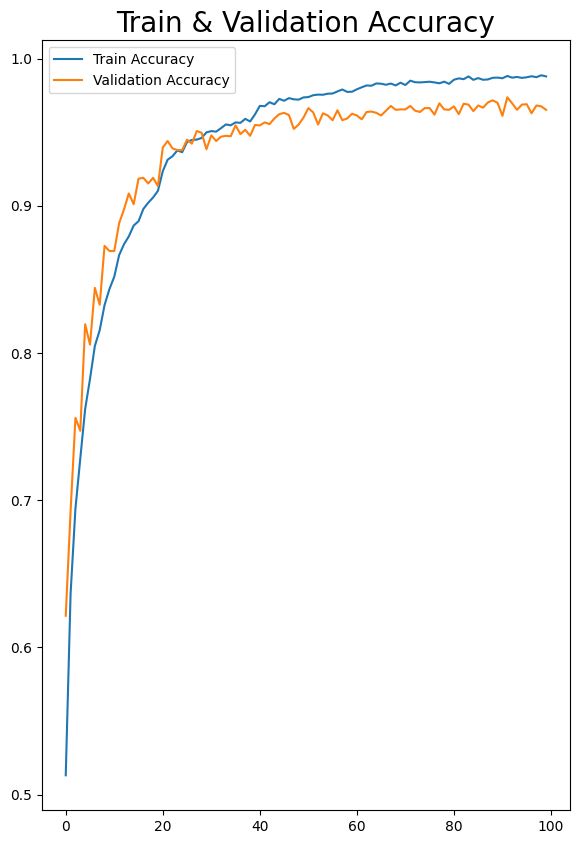

In [28]:
plt.figure(figsize=(15, 10))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_['train_acc'], label='Train Accuracy')
plt.plot(hist_['val_acc'], label='Validation Accuracy')
plt.title('Train & Validation Accuracy', fontsize=20)
plt.legend()

plt.show()

# Evaluating Model Performance
Evaluate the trained model on the test set and calculate the accuracy and confusion matrix.

In [29]:
test_loss = 0.0
correct = 0
total = 0

# Disable gradient calculation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
avg_loss = test_loss / len(test_loader)
accuracy = correct / total

print(f'Test Loss = {avg_loss:.4f}')
print(f'Test Accuracy = {accuracy:.4f}')

Test Loss = 0.0970
Test Accuracy = 0.9673


# Visualizing Model Predictions
Displays images from the test set along with the model's predicted labels to assess its performance.

<ipython-input-30-a1e072ba1af8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_2.pth"))



Classification Report:
              precision    recall  f1-score   support

          AD       0.95      0.99      0.97       896
          CN       1.00      1.00      1.00       647
        EMCI       0.96      0.95      0.95       960
        LMCI       0.95      0.93      0.94       896

    accuracy                           0.96      3399
   macro avg       0.96      0.96      0.96      3399
weighted avg       0.96      0.96      0.96      3399


Confusion Matrix:
[[885   2   2   7]
 [  0 647   0   0]
 [ 15   0 908  37]
 [ 27   0  40 829]]


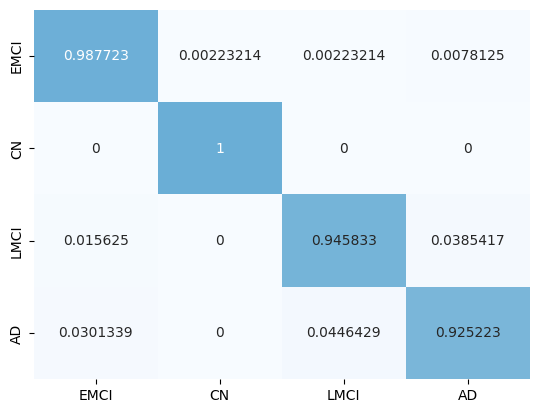

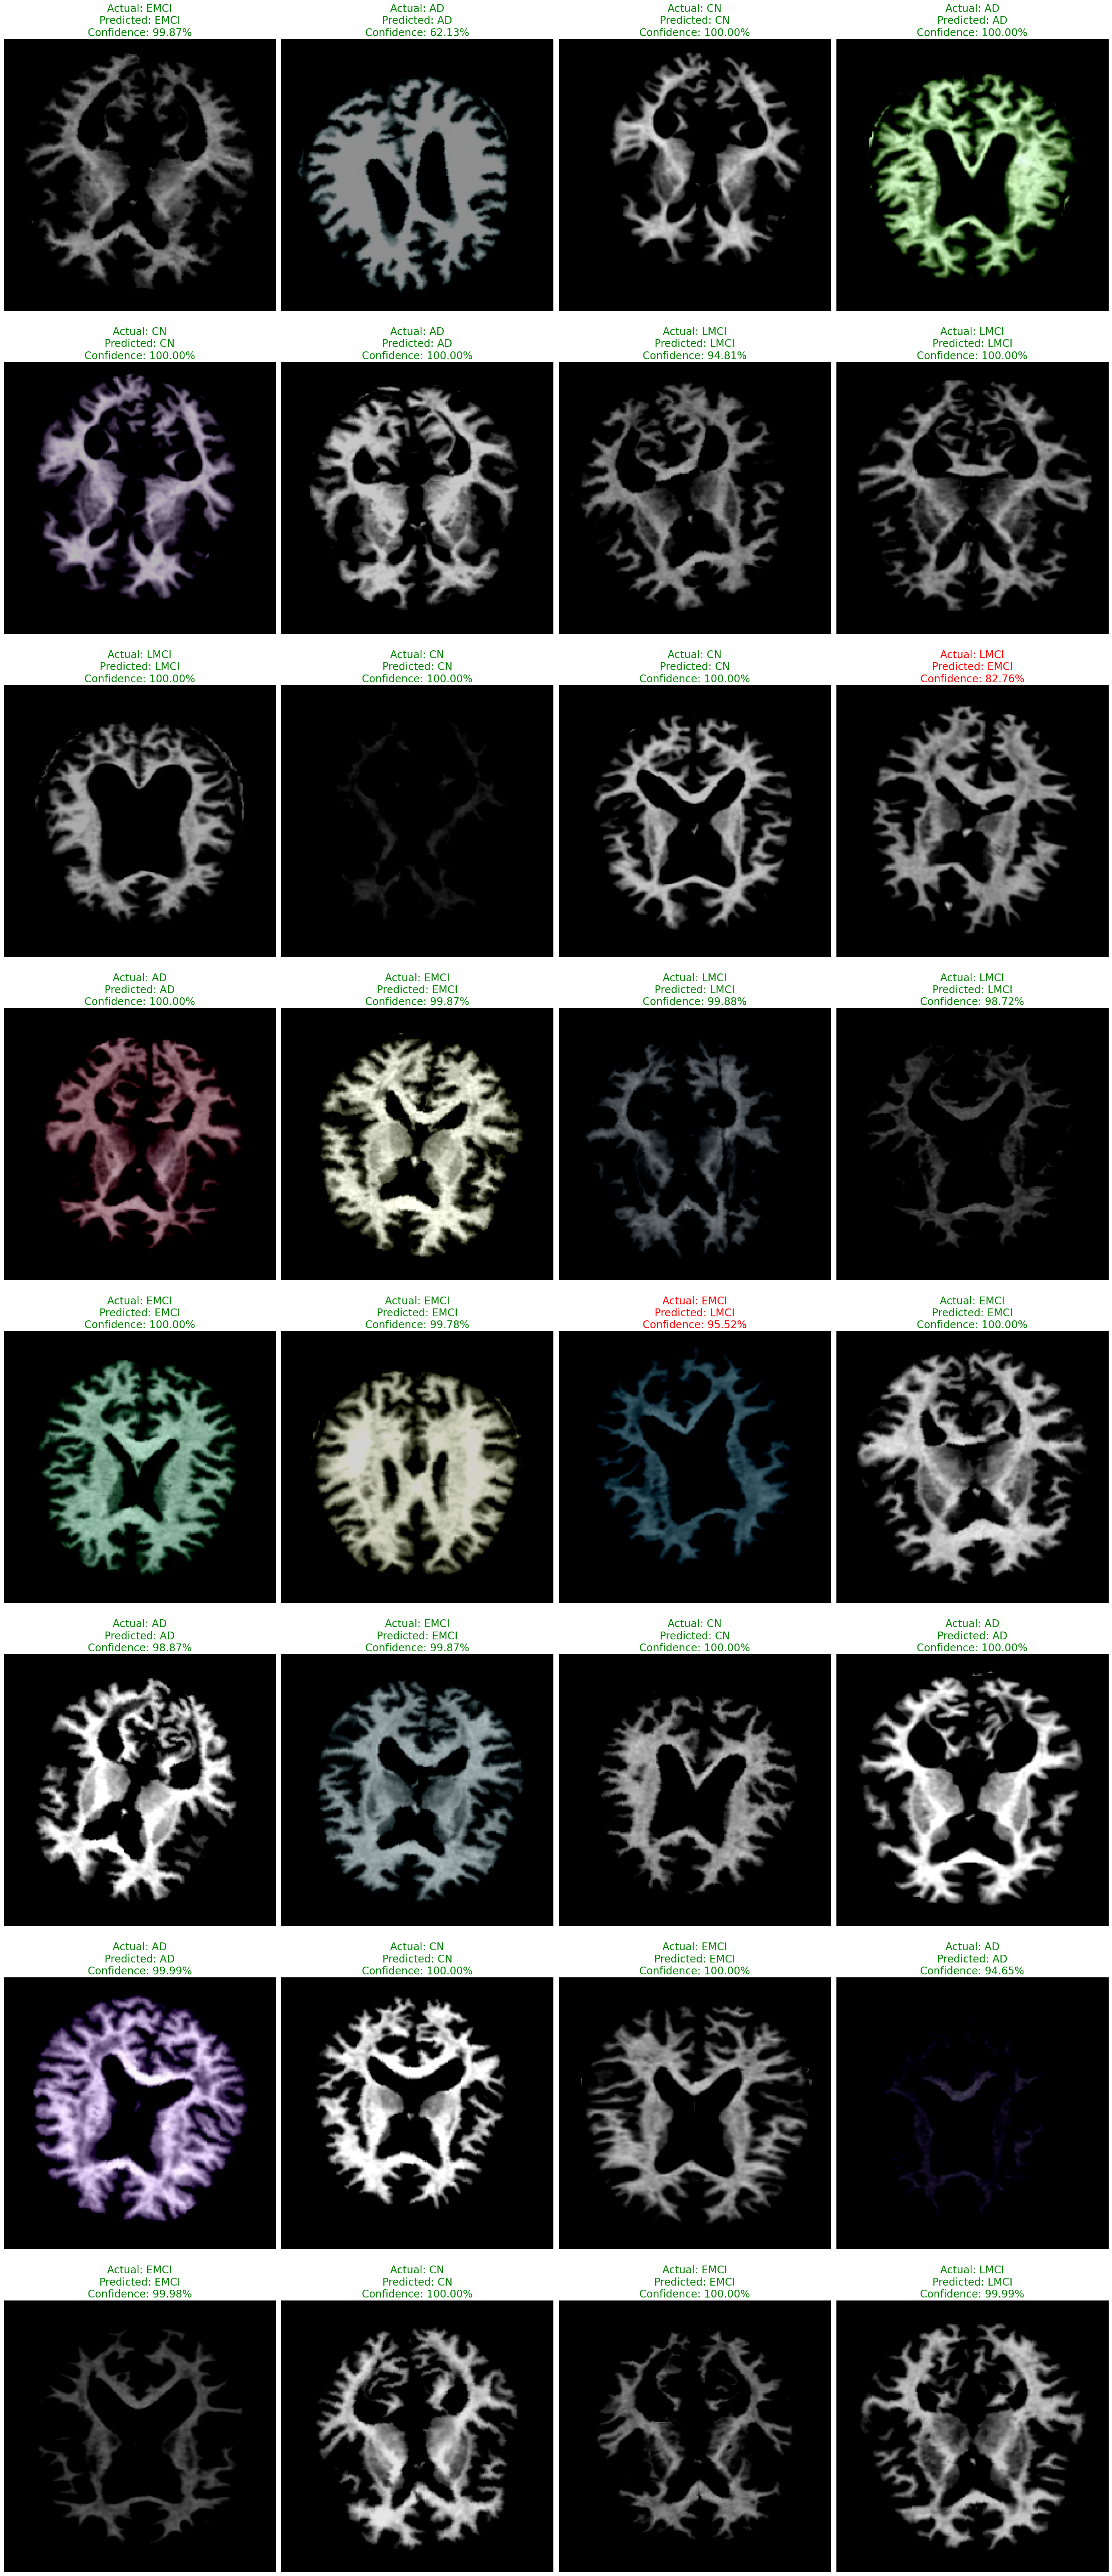

In [30]:
model.load_state_dict(torch.load("best_model_2.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

CM = confusion_matrix(y_true,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
print("\nConfusion Matrix:")
print(CM)

# Visualize Predictions
fig, axes = plt.subplots(8, 4, figsize=(30, 70))
axes = axes.ravel()

for i, (inputs, labels) in enumerate(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    for j in range(min(len(inputs), 32)):
        ax = axes[j]
        img = inputs[j].cpu().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')
        actual_label = label_encoder.inverse_transform([labels[j].item()])[0]
        predicted_label = label_encoder.inverse_transform([predicted[j].item()])[0]
        confidence = torch.softmax(outputs[j], dim=0).max().item() * 100
        color = 'green' if labels[j] == predicted[j] else 'red'
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}%", fontsize=20, color=color)
    break

plt.tight_layout()
plt.show()